# Seminar 4. Text classification using CNN

Parameters of the task

In [50]:
import torch
import torch.nn as nn
import pandas as pd
from razdel import sentenize, tokenize
from collections import Counter, OrderedDict
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import vocab

In [92]:
# Task
max_words = 1000
max_len = 40
num_classes = 2

# Training
epochs = 12
batch_size = 256
print_batch_n = 100

Let's download datasets

In [46]:
import re
import os

dir_path = "/Users/igorpostoev/Projects/Postgraduate/author_classification_task/sources/"

def get_raw_text_from_dir(path):
    contents = []
    
    for filename in os.listdir(path):
        if not filename.endswith(".txt"):
            continue
        filepath = path + filename
        
        # read input, remove redudant escape chars
        with open(filepath) as f:
            contents += [re.sub('[^А-Яа-я0-9 .,!?:;()]+,-', '', s) for s in f.readlines()]
    contents = ' '.join(contents)
    
    return contents

def get_raw_text_from(path):
    contents = []
    if not path.endswith(".txt"):
        return contents
        # read input, remove redudant escape chars
    with open(path) as f:
        contents += [re.sub('[^А-Яа-я0-9 .,!?:;()]+,-', '', s) for s in f.readlines()]
    contents = ' '.join(contents)
    return contents

bulgakov_raw_data = get_raw_text_from_dir(dir_path + "bulgakov/")
gogol_raw_data = get_raw_text_from_dir(dir_path + "gogol/")

In [48]:
def create_datadarame(raw_text, sentenizer, label):
    sentences = [s.text.replace('\xa0', '').replace('\n', '') for s in sentenizer(raw_text)]
    labels = [label for item in range(0, len(sentences))]
    df = pd.DataFrame({
        "sentence": sentences,
        "label": labels,
    })
    return df

In [51]:
bul_df = create_datadarame(bulgakov_raw_data, sentenize, 0)
gog_df = create_datadarame(gogol_raw_data, sentenize, 1)
bul_df = bul_df.iloc[:int(len(bul_df) * 0.7)]
merged_df = pd.merge(bul_df, gog_df, how='outer')
#shuffle here
merged_df = merged_df.sample(frac=1)
all_items = merged_df.values
num_validate = int(len(all_items) * 0.2)
num_test = int(len(all_items) * 0.1)

train_items = all_items[:len(all_items)- num_test - num_validate]
val_items = all_items[len(train_items): len(train_items) + num_validate]
test_items = all_items[len(train_items) + num_test: len(train_items) + num_test + num_validate]

In [5]:
import pandas
#base_url = "https://github.com/madrugado/keras-tutorial/raw/master/data"
base_url = "."
df_train = pandas.read_csv(f"{base_url}/train.csv")
df_test = pandas.read_csv(f"{base_url}/test.csv")
df_val = pandas.read_csv(f"{base_url}/val.csv")

## Preprocessing

Let's create a corpus of the text

In [62]:
train_corpus = " ".join(merged_df["sentence"])
train_corpus = train_corpus.lower()

and find all tokents

In [63]:
import nltk
from nltk.tokenize import word_tokenize
#nltk.download("punkt")

tokens = word_tokenize(train_corpus)

Now filter ofnly numbers and words

In [65]:
tokens_filtered = [word for word in tokens if word.isalnum()]

Collect top N words in the corpus

In [70]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

Let's looks at them

Now we are building vocabulary to encode every token using index

In [71]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [73]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [74]:
x_train = np.array([text_to_sequence(item[0], max_len) for item in train_items], dtype=np.int32)
x_test = np.array([text_to_sequence(item[0], max_len) for item in val_items], dtype=np.int32)
x_val = np.array([text_to_sequence(item[0], max_len) for item in test_items], dtype=np.int32)

In [76]:
x_train.shape

(16104, 40)

Let's prepare class labels

In [151]:
y_train = np.array([item[1] for item in train_items], dtype=np.int32)
y_val = np.array([item[1] for item in val_items], dtype=np.int32)

In [79]:
y_train.shape

(16104,)

## Network

In [80]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [81]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

## Training

In [152]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [162]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.CrossEntropyLoss()
    
train_dataset = DataWrapper(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

Net(
  (embedding): Embedding(1000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 177538


In [154]:
loss_history = []

for epoch in range(1,epochs+1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        #data = data.cuda()
        #target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print(f"Step {i}: {loss=}")
            loss_history.append(loss)

Train epoch 1/12
Step 0: loss=0.7022953033447266
Train epoch 2/12
Step 0: loss=0.5117802619934082
Train epoch 3/12
Step 0: loss=0.34333130717277527
Train epoch 4/12
Step 0: loss=0.31609201431274414
Train epoch 5/12
Step 0: loss=0.22612294554710388
Train epoch 6/12
Step 0: loss=0.19883811473846436
Train epoch 7/12
Step 0: loss=0.14871074259281158
Train epoch 8/12
Step 0: loss=0.15335337817668915
Train epoch 9/12
Step 0: loss=0.13750271499156952
Train epoch 10/12
Step 0: loss=0.10563881695270538
Train epoch 11/12
Step 0: loss=0.17409580945968628
Train epoch 12/12
Step 0: loss=0.15740561485290527


In [145]:
batches = [l[0] for l in val_loader]
trues = [l[1] for l in val_loader]

In [144]:
labels = model(batches[0])

In [155]:
val_dataset[:100]

(tensor([[  0,   0,   0,  ...,  79,   4, 247],
         [  0,   0,   0,  ...,   2,   2,  58],
         [  0,   0,   0,  ..., 397,   1,  29],
         ...,
         [  0,   0,   0,  ...,   4, 255, 334],
         [  0,   0,   0,  ...,  45,  40,  11],
         [  0,   0,   0,  ...,   7,  80,   6]]),
 tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
         0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
         0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
         1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
         1, 1, 0, 0]))

In [122]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
evaluate()

In [161]:
evaluate(val_loader)

0.45521739130434785

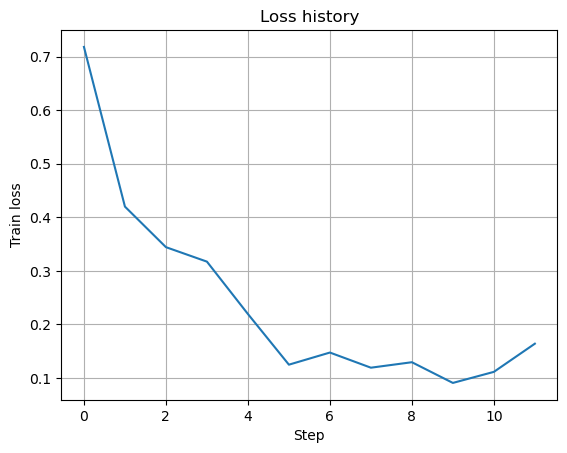

In [98]:
import matplotlib.pyplot as plt
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history)

In [44]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [28]:
model.eval()

for epoch in range(1,epochs+1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(test_loader):
        # compute output
        output = model(data)
        break

### Task
Basing on the previous cell add code to infer your model for a particular input text.

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [116]:
inp1 = torch.from_numpy(np.array(text_to_sequence("Теперь, когда прошло десять лет, жалость и страх, вызванные записями, конечно, ушли. Это естественно. Но, перечитав эти записки теперь, когда тело Полякова давно истлело, а память о нем совершенно исчезла, я сохранил к ним интерес. Может быть, они нужны? Беру на себя смелость решить это утвердительно. Анна К. умерла в 1922 году от сыпного тифа и на том же участке, где работала. Амнерис – первая жена Полякова – за границей. И не вернется.", max_len))).long()
inp2 = torch.from_numpy(np.array(text_to_sequence("Ребенка окрестили, причем он заплакал и сделал такую гримасу, как будто бы предчувствовал, что будет титулярный советник. Итак, вот каким образом произошло все это. Мы привели потому это, чтобы читатель мог сам видеть, что это случилось совершенно по необходимости и другого имени дать было никак невозможно. Когда и в какое время он поступил в департамент и кто определил его, этого никто не мог припомнить. Сколько не переменялось директоров и всяких начальников, его видели всё на одном и том же мест", max_len))).long()

In [117]:
inp = torch.stack([inp1, inp2])

In [102]:
inp

tensor([[ 25,   2,  12,   1,   2, 347, 420,   9,   1, 338,   9,   1,  18,   9,
         268,  49,  84,   5,  95,  72, 116, 139,  17,  89,   2, 221, 349, 352,
          82,   4,   2, 113,   4, 393,  84,  12,  45,   8, 580,   1],
        [ 25,   2,  12,   1,   2, 347, 420,   9,   1, 338,   9,   1,  18,   9,
         268,  49,  84,   5,  95,  72, 116, 139,  17,  89,   2, 221, 349, 352,
          82,   4,   2, 113,   4, 393,  84,  12,  45,   8, 580,   1]])

In [118]:
 model(inp)

tensor([[ -8.6818,   4.6677],
        [-12.8849,  10.3866]], grad_fn=<AddmmBackward0>)